# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Скачивание данных

In [ ]:
!pip install scipy==1.1.0

In [ ]:
import numpy as np
import os
from scipy.misc import imread,imresize
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64, dimy=64):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: imresize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

# Vanilla Autoencoder (2 балла)

## Prepare the data


In [ ]:
import numpy as np
from tqdm import tqdm, tqdm_notebook


from torchvision import transforms
from torchvision.datasets import MNIST

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset import fetch_dataset
data, attrs = fetch_dataset()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [ ]:
data = np.array(data / 255, dtype='float32')

In [ ]:
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
# у нас цветные изображения
N_CHANNELS = 3

TRAIN_SIZE = 10000
VAL_SIZE = data.shape[0] - TRAIN_SIZE

In [ ]:
IMAGE_H, IMAGE_W

(64, 64)


Разбейте выборку картинок на train и val:

In [ ]:
X_train = data[:TRAIN_SIZE]
X_val = data[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]

Напишем вспомогательную функцию, которая будет выводить n_row $\cdot$ n_col первых картинок в массиве images:

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        inp = images[i].reshape(64, 64, 3)
        plt.imshow(inp, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

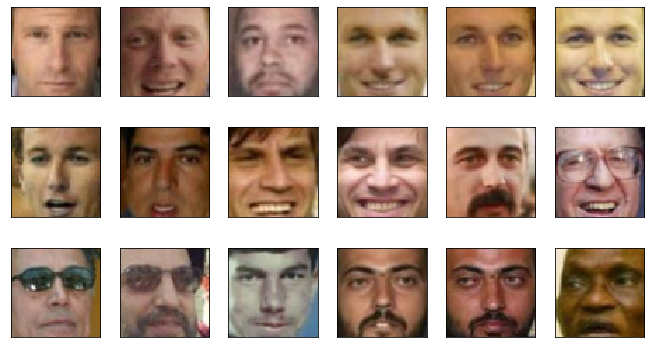

In [ ]:
plot_gallery(X_train, IMAGE_H, IMAGE_W)

In [ ]:
X_train[0].max(), X_train[0].min()

(0.93333334, 0.0)

Осталось привести картинки к тензорам из PyTorch, чтобы можно было потом скармливать их автоэнкодеру: 

In [ ]:
train_dataloader = data_utils.DataLoader(X_train, batch_size=32, drop_last=True)
val_dataloader = data_utils.DataLoader(X_val, batch_size=32, drop_last=True)

Это блок с функциями обучения, их я буду использовать в проекте. Такой подход был взят с курса DeepNLP https://github.com/DanAnastasyev/DeepNLP-Course


In [ ]:
def onehot(x):
    result_tensor = torch.zeros(x.shape[0], 2)
    
    for i in range(0, x.shape[0]):
        if x[i] >= 0:
            result_tensor[i] = torch.Tensor([1, 0])
        else:
            result_tensor[i] = torch.Tensor([0, 1])

    return result_tensor

def do_epoch(model, loss_func, data, optimizer=None, name=None, cvae=False):
    epoch_loss = []
    plot_dir = []
    
    is_train = not optimizer is None

    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for dt in data:
                if cvae:
                    inputs = dt[0].view(-1, inp_size*inp_size*3).to(device).float()
                    labels = onehot(dt[1]).to(device)
                    faces = torch.cat((inputs, labels), dim=-1)
                    model_output = model(faces, labels)

                else:
                    inputs = dt.view(-1, inp_size*inp_size*3).to(device).float()
                    model_output = model(inputs)

                loss = loss_func(inputs, model_output)

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 5)
                    optimizer.step()
                
                epoch_loss.append(loss.item())
                
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(
                    name, loss.item()))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}'.format(
                name, torch.mean(torch.FloatTensor(epoch_loss))))
            
            if not optimizer:
                #print(inputs.shape)
                if not cvae:
                    plot_dir.append(inputs.detach().cpu().view(-1, 3, inp_size, inp_size).numpy())
                    plot_dir.append(model(inputs.float())[0].detach().cpu().view(-1, 3, inp_size, inp_size).numpy())
                else:
                    plot_dir.append(dt[0].detach().cpu().view(-1, 3, inp_size, inp_size).numpy())
                    plot_dir.append(model(faces.float(), labels)[0].detach().cpu().numpy().reshape(-1, inp_size, inp_size, 3))
                
    return plot_dir


def fit(model, loss, optimizer, train_data, val_data=None, epochs_count=1, cvae=False, show_img_val=10):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train = do_epoch(model, loss, train_data, optimizer,
                              name_prefix + 'Train:', cvae)

        if not val_data is None:
            x_val, reconstruction = do_epoch(model, loss, val_data, None,
                                         name_prefix + '  Val:', cvae)
            

            if epoch % show_img_val == 0:
                plot_gallery(x_val, inp_size, inp_size, n_row=1, n_col=5)
                plot_gallery(reconstruction, inp_size, inp_size, n_row=1, n_col=5)

## Autoencoder

Why to use all this complicated formulaes and regularizations, what is the need for variational inference? To analyze the difference, let's first train just an autoencoder on the data:
<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

In [ ]:
inp_size = 64
dim_code = 100 # размер латентного вектора, т.е. code
inp_size

64

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, dim_code):
       # <определите архитектуры encoder и decoder>
       super(Autoencoder, self).__init__()
       self.encoder = nn.Sequential(
            nn.Linear(input_dim * input_dim * 3, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, dim_code),
            )
       
       self.decoder = nn.Sequential(
            nn.Linear(dim_code, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, input_dim * input_dim * 3),
            )
        
    def forward(self, x):
        """
        <реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)>
        """
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        
        return reconstruction, latent_code

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

Подсказка: если x_val -- каринка, а reconstruction -- ее реконструкция автоэнкодером, то красиво вывести эту каритинку и ее реконструкцию можно с помощью функции plot_gallery вот так:

*plot_gallery([x_val, reconstruction], image_h, image_w, n_row=1, n_col=2)*

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

[1 / 70]   Val: Average Loss = 0.01875: 100%|██████████| 98/98 [00:00<00:00, 153.07it/s]


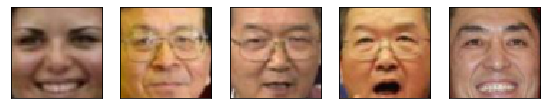

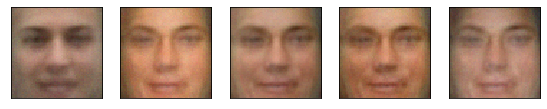

[11 / 70]   Val: Average Loss = 0.01385: 100%|██████████| 98/98 [00:00<00:00, 157.79it/s]


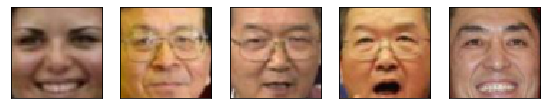

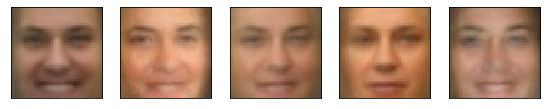

[21 / 70]   Val: Average Loss = 0.01197: 100%|██████████| 98/98 [00:00<00:00, 149.82it/s]


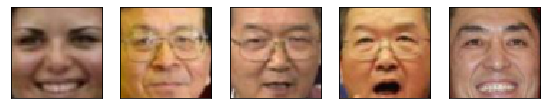

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


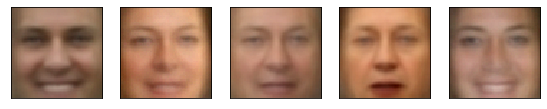

[31 / 70]   Val: Average Loss = 0.01071: 100%|██████████| 98/98 [00:00<00:00, 135.17it/s]


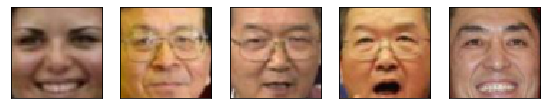

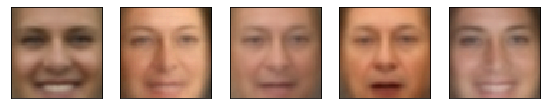

[41 / 70]   Val: Average Loss = 0.00848: 100%|██████████| 98/98 [00:00<00:00, 168.04it/s]


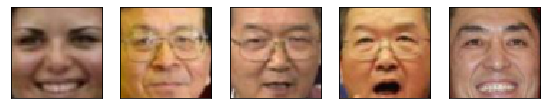

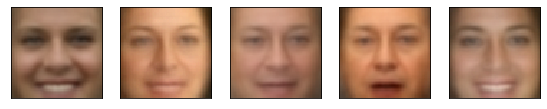

[51 / 70]   Val: Average Loss = 0.00741: 100%|██████████| 98/98 [00:00<00:00, 137.08it/s]


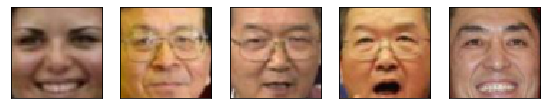

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


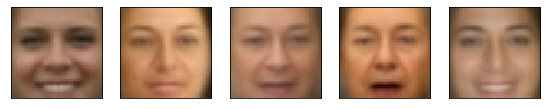

[61 / 70]   Val: Average Loss = 0.00675: 100%|██████████| 98/98 [00:00<00:00, 152.02it/s]


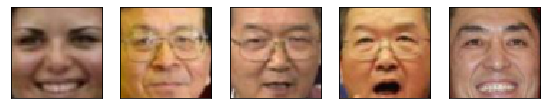

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


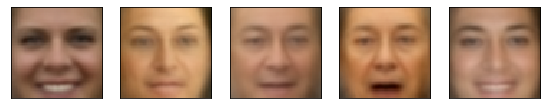

[70 / 70]   Val: Average Loss = 0.00651: 100%|██████████| 98/98 [00:00<00:00, 136.32it/s]


In [ ]:
def mse(x, y):
    y = y[0]
    loss = nn.MSELoss().to(device)
    return loss(x, y)


autoencoder = Autoencoder(inp_size, dim_code).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

fit(autoencoder, mse, optimizer, train_dataloader, val_dataloader, epochs_count=70)

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


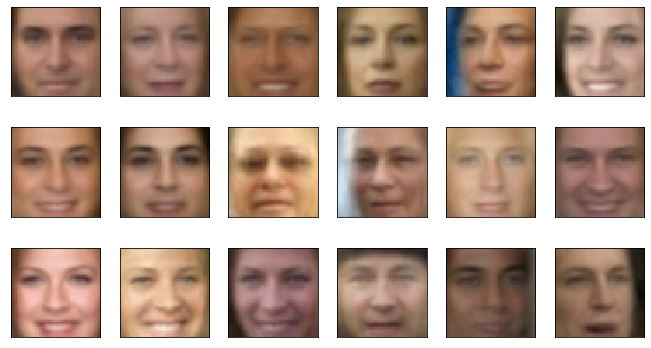

--------------------------------------------------------------------------------


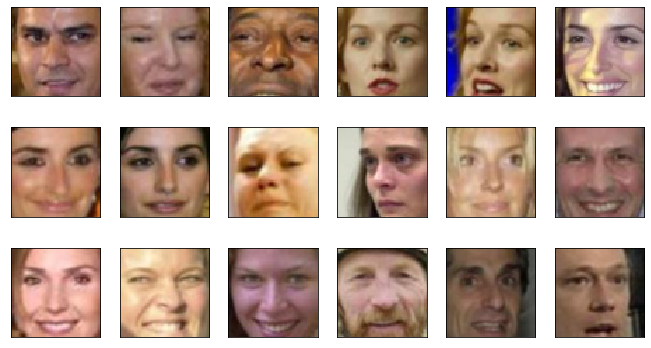

In [ ]:
val_dataloader_vis = data_utils.DataLoader(X_val, batch_size=32, drop_last=True)
val_data = next(iter(val_dataloader_vis))
val_data_tr = val_data.view(-1, inp_size * inp_size * 3).to(device)
result = autoencoder(val_data_tr.float())[0].detach().cpu().view(-1, 3, inp_size, inp_size).numpy()
plot_gallery_tensor(result, IMAGE_H, IMAGE_W)
print('-'*80)
plot_gallery_tensor(val_data.detach().cpu().view(-1, 3, inp_size, inp_size).numpy(), IMAGE_H, IMAGE_W)

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


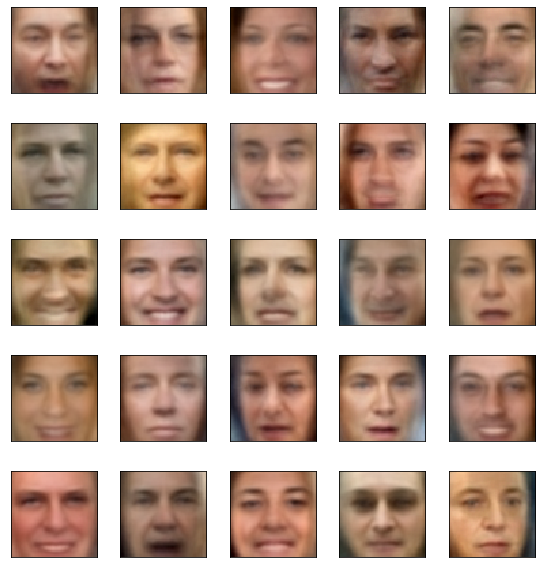

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = torch.Tensor(np.random.randn(25, inp_size, inp_size, 3)).to(device)
output, _ = autoencoder(z.view(-1, inp_size * inp_size * 3))
output = output.data.cpu().reshape(-1, 3, inp_size, inp_size)
plot_gallery(output, IMAGE_H, IMAGE_W, n_row=5, n_col=5)

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
attrs.head()

Male     Asian  ... Wearing Necktie Wearing Necklace
0   1.56835  -1.88904  ...        0.694007        -0.826609
1  0.169851 -0.982408  ...         0.66676        -0.496559
2  0.997749  -1.36419  ...        0.144262        -0.841231
3   1.12272   -1.9978  ...        0.475941        -0.447025
4   1.07821   -2.0081  ...       -0.760774        -0.410152

[5 rows x 73 columns]

In [ ]:
attrs['Smiling'].min(), attrs['Smiling'].max()

(-2.68659390331, 2.83999377045)

Я также поменяю пол, чтобы не было конфузов

улыбаки


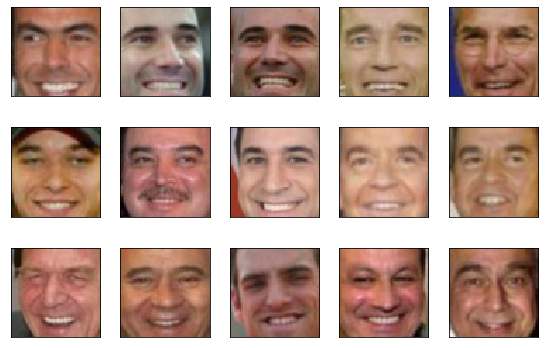

не улыбаки


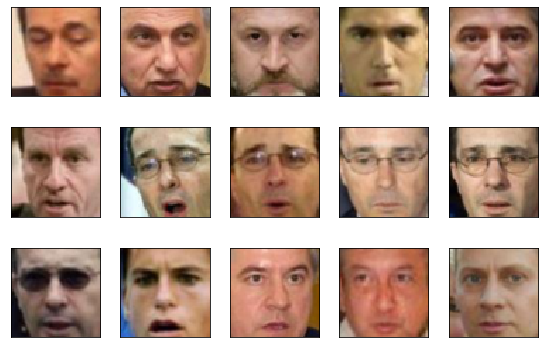

In [ ]:
# мужчины с улыбкой
attrs = attrs.astype(float)
smile_idx = attrs.query("Male > 1 and Smiling > 2").head(15).index.values
smile_img = data[smile_idx]

# мужчины без улыбки
unsmile_idx = attrs.query("Male > 1 and Smiling < -1.75").head(15).index.values
unsmile_img = data[no_smile_idx]

print('улыбаки')
plot_gallery(smile_img, IMAGE_H, IMAGE_W, n_row=3, n_col=5)
print('не улыбаки')
plot_gallery(unsmile_img, IMAGE_H, IMAGE_W, n_row=3, n_col=5)

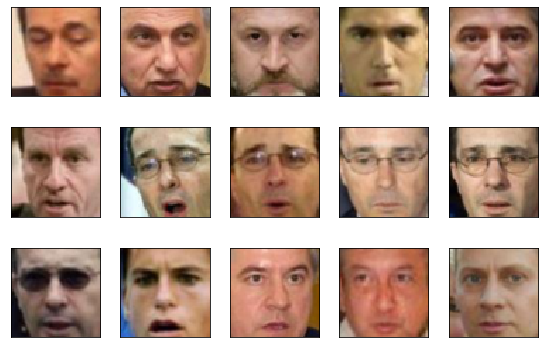

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


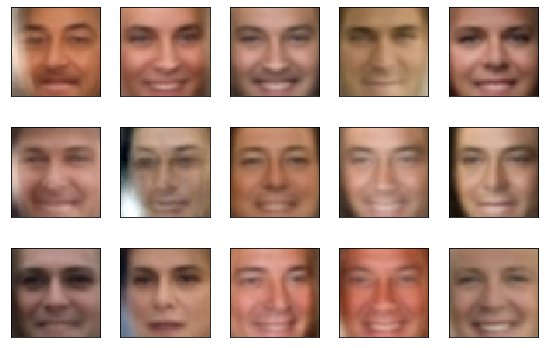

In [ ]:
def to_latent(img, model):
        inputs = torch.Tensor(img).view(-1, 64*64*3).to(device)
        model.eval()
        output = model.encoder(inputs)        
        return output

def from_latent(latent_vec, model):
    with torch.no_grad():
        latent_vec = latent_vec.to(device)
        model.eval()
        output = model.decoder(latent_vec)        
        return output

smile_latent = torch.mean(to_latent(smile_img, autoencoder), dim=0)
untismiles_latent = torch.mean(to_latent(unsmile_img, autoencoder), dim=0)

# разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей
smile_vec = smile_latent - untismiles_latent

original_images = []
generated_images = []

# добавляем улыбки
for id in no_smile_idx:
    img = data[id:id+1]
    original_images.append(img)
    latent_vec = to_latent(img, autoencoder)
    latent_vec[0] += smile_vec
    img_output = from_latent(latent_vec, autoencoder).view(-1,64,64,3).cpu()
    generated_images.append(img_output)
    
plot_gallery(original_images, IMAGE_H, IMAGE_W, n_row=3, n_col=5)
plot_gallery(generated_images, IMAGE_H, IMAGE_W, n_row=3, n_col=5)

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (2 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [ ]:
class vanila_VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        """
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        """
        super(vanila_VAE, self).__init__()
        self.encoder_fc1 = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, hidden_size),
            nn.ReLU()
        )
        self.relu = nn.ReLU()

        self._mu = nn.Linear(hidden_size, latent_size)
        self._logsigma = nn.Linear(hidden_size, latent_size)

        self.decoder_fc1 = nn.Sequential(
            nn.Linear(latent_size, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, input_size)

        )
        

    def encode(self, x):
        """
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>
        """
        x = self.encoder_fc1(x)

        mu = self._mu(x)
        logsigma = self._logsigma(x)

        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        """
        Функция сэмплирует латентные векторы из нормального распределения с параметрами mu и sigma
        """
        if self.training:
            std = torch.exp(logsigma * 0.5)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        """
        <реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>
        """
        reconstruction = self.decoder_fc1(z)

        return torch.sigmoid(reconstruction)

    def forward(self, x):
        """
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        """
        mu, logsigma = self.encode(x)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return reconstruction, mu, logsigma
    
    def get_latent_code(self, x):
        mu, logsigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, logsigma)
        return latent_code

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + 2 * logsigma - mu * mu - torch.exp(2 * logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = F.binary_cross_entropy(reconstruction, x)
    return loss

def loss_vae(x, model_output):
    reconstruction = model_output[0]
    mu = model_output[1]
    logsigma = model_output[2]

    size = x.size(0) * x.size(1)
    return (KL_divergence(mu, logsigma) / size) + log_likelihood(x, reconstruction)

И обучим модель:

[1 / 100]   Val: Average Loss = 0.65094: 100%|██████████| 98/98 [00:00<00:00, 153.69it/s]


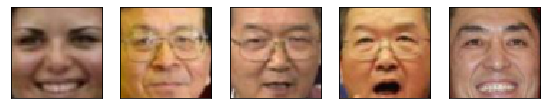

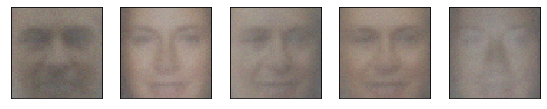

[11 / 100]   Val: Average Loss = 0.62131: 100%|██████████| 98/98 [00:00<00:00, 159.35it/s]


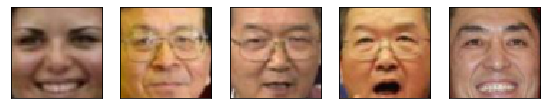

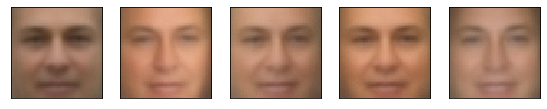

[21 / 100]   Val: Average Loss = 0.61905: 100%|██████████| 98/98 [00:00<00:00, 154.69it/s]


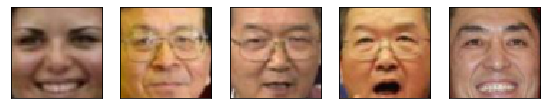

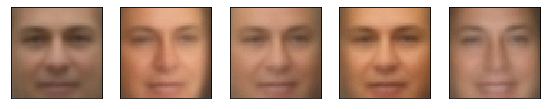

[31 / 100]   Val: Average Loss = 0.61664: 100%|██████████| 98/98 [00:00<00:00, 153.76it/s]


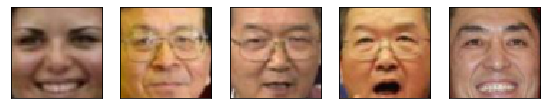

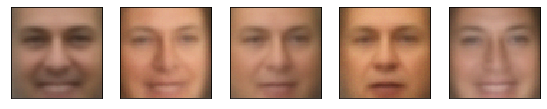

[41 / 100]   Val: Average Loss = 0.61517: 100%|██████████| 98/98 [00:00<00:00, 150.87it/s]


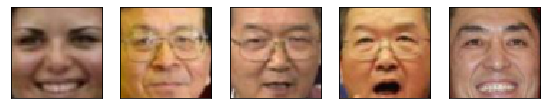

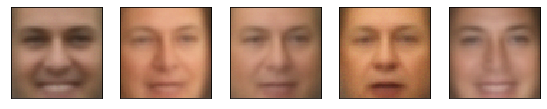

[51 / 100]   Val: Average Loss = 0.61524: 100%|██████████| 98/98 [00:00<00:00, 164.87it/s]


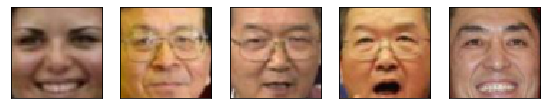

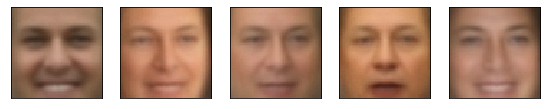

[61 / 100]   Val: Average Loss = 0.61427: 100%|██████████| 98/98 [00:00<00:00, 147.79it/s]


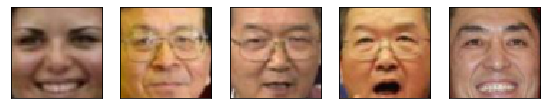

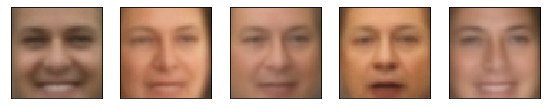

[71 / 100]   Val: Average Loss = 0.61390: 100%|██████████| 98/98 [00:00<00:00, 151.51it/s]


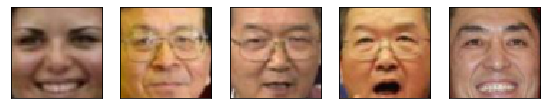

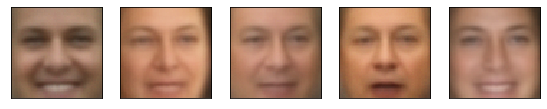

[81 / 100]   Val: Average Loss = 0.61390: 100%|██████████| 98/98 [00:00<00:00, 153.32it/s]


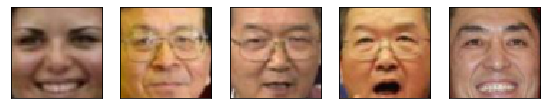

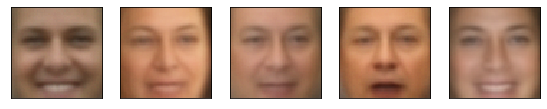

[91 / 100]   Val: Average Loss = 0.61347: 100%|██████████| 98/98 [00:00<00:00, 156.25it/s]


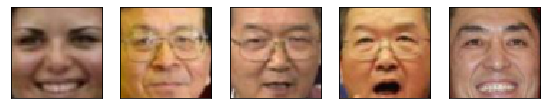

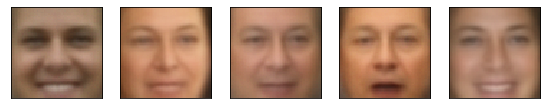

[100 / 100]   Val: Average Loss = 0.61297: 100%|██████████| 98/98 [00:00<00:00, 159.29it/s]


In [ ]:
hidden_size = 512

criterion = loss_vae
vanila_vae = vanila_VAE(inp_size*inp_size*3, hidden_size, latent_size=100).to(device)
optimizer = optim.Adam(vanila_vae.parameters(), lr=0.0001)

fit(vanila_vae, criterion, optimizer, train_dataloader, val_dataloader, epochs_count=100)

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
import copy
vanila_vae_t = copy.deepcopy(vanila_vae)

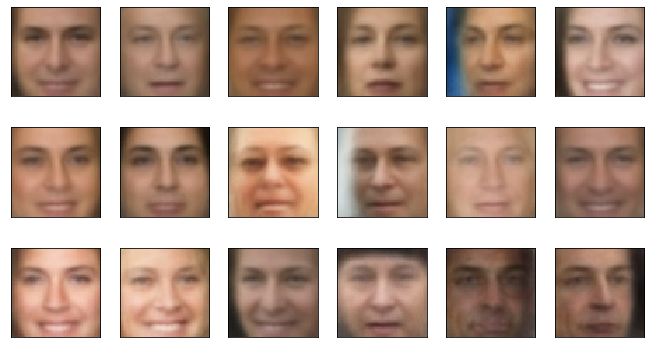

--------------------------------------------------------------------------------


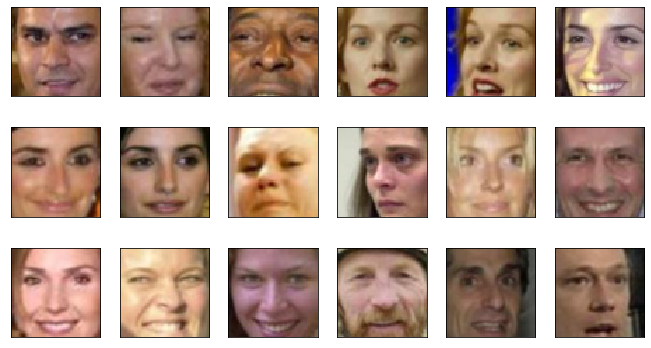

In [ ]:
val_dataloader_vis = data_utils.DataLoader(X_val, batch_size=32, drop_last=True)
val_data = next(iter(val_dataloader_vis))
val_data_tr = val_data.view(-1, inp_size * inp_size * 3).to(device)
result = vanila_vae_t(val_data_tr.float())[0].detach().cpu().view(-1, 3, inp_size, inp_size)
plot_gallery(result, IMAGE_H, IMAGE_W)
print('-'*80)
plot_gallery(val_data.detach().cpu().view(-1, 3, inp_size, inp_size), IMAGE_H, IMAGE_W)

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

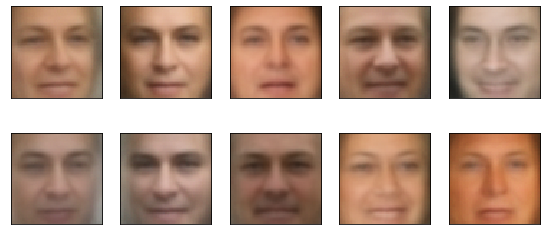

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
vanila_vae_t.eval()
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = vanila_vae_t.decode(torch.FloatTensor(z).view(-1, 100).to(device))
plot_gallery(output.data.cpu().numpy(), IMAGE_H, IMAGE_W, n_row=2, n_col=5)

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

Буду использовать UMAP, из-за его скорости работы

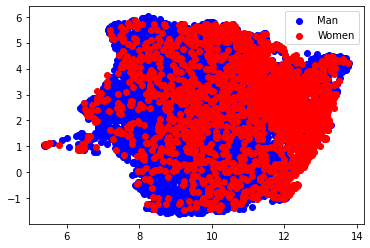

In [ ]:
import umap
latent_representation = vanila_vae_t.get_latent_code(torch.Tensor(X_train).view(-1, 64*64*3).to(device))
X_embedded = umap.UMAP(n_neighbors=10, n_components=2).fit_transform(latent_representation.detach().cpu().numpy())

man = attrs['Male'][:TRAIN_SIZE][attrs['Male'] >= 0].index
women = attrs['Male'][0:TRAIN_SIZE][attrs['Male'] < 0].index

man = [X_embedded[i] for i in man]
women = [X_embedded[j] for j in women]

man = np.array(man)
women = np.array(women)

plt.figure()

plt.scatter(man[:, 0], man[:, 1], label='Man', color='blue')

plt.scatter(women[:, 0], women[:, 1], label='Women', color='red')
plt.legend()

plt.show()

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

### MNIST

In [ ]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        inp = images[i].reshape((h, w, 1))
        plt.imshow(inp, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [ ]:
mnist_train = MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
mnist_dataloader_train = data_utils.DataLoader(mnist_train, batch_size=16)

mnist_val = MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)
mnist_dataloader_val = data_utils.DataLoader(mnist_val, batch_size=16)


In [ ]:
class CVAE_MNIST(nn.Module): 
    def __init__(self, input_size, hidden_size, n_class=10, latent_size=2):
        super(CVAE_MNIST, self).__init__()
        self.encoder_fc1 = nn.Linear(input_size + n_class, hidden_size) 
        self.encoder_fc2 = nn.Linear(hidden_size, hidden_size) 
        self.lrelu = nn.LeakyReLU()
        self._mu = nn.Linear(hidden_size, latent_size)
        self._logsigma = nn.Linear(hidden_size, latent_size)
 
        self.decoder_fc1 = nn.Linear(latent_size + n_class, hidden_size)
        self.decoder_fc2 = nn.Linear(hidden_size, input_size)
 
 
    def encode(self, x, label):
        inp = torch.cat([x, label], dim=1)
        enc = self.lrelu(self.encoder_fc1(inp))
        enc = self.lrelu(self.encoder_fc2(enc))
 
        mu = self._mu(enc)
        logsigma = self._logsigma(enc)
 
        return mu, logsigma
 
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = logsigma.exp()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add(mu)
        else:
            return mu
 
    def decode(self, z, label):
        dec = torch.cat([z, label], dim=1)
        reconstruction = self.lrelu(self.decoder_fc1(dec))
        reconstruction = self.decoder_fc2(reconstruction)
        return torch.sigmoid(reconstruction)
 
    def forward(self, x, label):
        mu, logsigma = self.encode(x, label)
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, label)
 
        return mu, logsigma, reconstruction

In [ ]:
def onehot(labels, cl_size):
    tr = torch.zeros(labels.size(0), cl_size)
    for i, label in enumerate(labels):
        tr[i, label] = 1
    return tr.to(device)

def do_epoch_mnist(model, loss_func, data, optimizer=None, name=None):
    epoch_loss = []
    plot_dir = []
    
    is_train = not optimizer is None

    name = name or ''
    model.train(is_train)
    
    batches_count = len(data)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for inputs, label in data:
                inputs = inputs.view(-1, 28 * 28*1).to(device)
                labels = onehot(label, 10)
                mu, logsigma, decoder_out = model(inputs.float(), labels)

                loss = loss_func(inputs.float(), mu, logsigma, decoder_out.float())


                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 5)
                    optimizer.step()
                
                epoch_loss.append(loss)
                
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}'.format(
                    name, loss))

            progress_bar.set_description('{:>5s} Average Loss = {:.5f}'.format(
                name, torch.mean(torch.FloatTensor(epoch_loss))))
            
            if not optimizer:
                plot_dir.append(inputs.detach().cpu().numpy().reshape(-1, 28, 28, 1))
                plot_dir.append(model(inputs.float(), labels)[2].detach().cpu().numpy().reshape(-1, 28, 28, 1))
                
    return plot_dir


def fit(model, loss, optimizer, train_data, val_data=None, epochs_count=1):
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train = do_epoch_mnist(model, loss, train_data, optimizer,
                              name_prefix + 'Train:')

        if not val_data is None:
            x_val, reconstruction = do_epoch_mnist(model, loss, val_data, None,
                                         name_prefix + '  Val:')
            

            if epoch % 5 == 0:
                plot_gallery(x_val, 28, 28, n_row=1, n_col=4)
                plot_gallery(reconstruction, 28, 28, n_row=1, n_col=4)

[1 / 30]   Val: Average Loss = 0.22305: 100%|██████████| 625/625 [00:03<00:00, 201.11it/s]


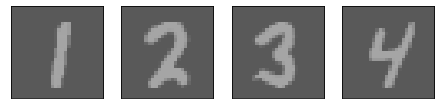

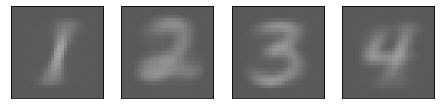

[6 / 30]   Val: Average Loss = 0.22036: 100%|██████████| 625/625 [00:02<00:00, 209.13it/s]


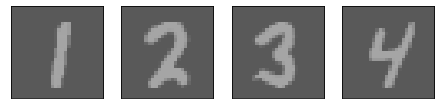

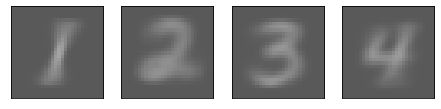

[11 / 30]   Val: Average Loss = 0.22017: 100%|██████████| 625/625 [00:02<00:00, 211.49it/s]


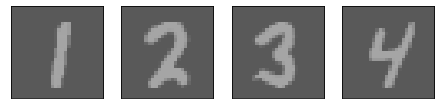

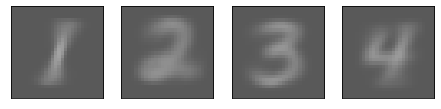

[16 / 30]   Val: Average Loss = 0.22000: 100%|██████████| 625/625 [00:03<00:00, 203.03it/s]


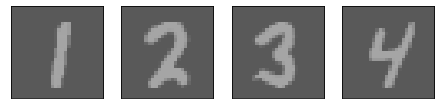

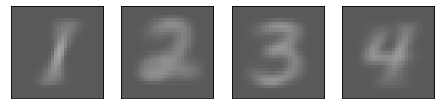

[21 / 30]   Val: Average Loss = 0.21987: 100%|██████████| 625/625 [00:03<00:00, 204.77it/s]


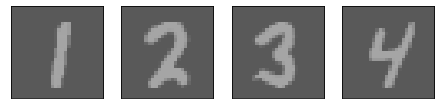

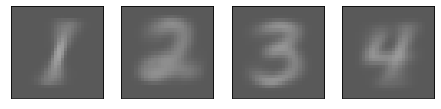

[26 / 30]   Val: Average Loss = 0.21974: 100%|██████████| 625/625 [00:03<00:00, 207.33it/s]


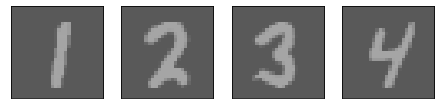

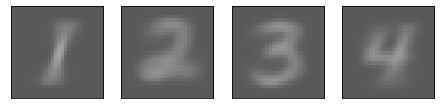

[30 / 30]   Val: Average Loss = 0.21966: 100%|██████████| 625/625 [00:02<00:00, 209.87it/s]


In [ ]:
hidden_size = 512

criterion = loss_vae
vanila_vae = CVAE_MNIST(28*28*1, hidden_size=hidden_size, n_class=10, latent_size=2).to(device)
optimizer = optim.Adam(vanila_vae.parameters(), lr=0.0001)

fit(vanila_vae, criterion, optimizer, mnist_dataloader_train, mnist_dataloader_val, epochs_count=30)

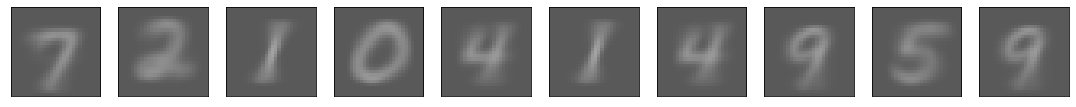

In [ ]:
val_dataloader_mnist = data_utils.DataLoader(mnist_val, batch_size=32)
val_data, val_label = next(iter(mnist_dataloader_val))

val_data = val_data.view(-1, 28*28).to(device)
val_label = onehot(val_label, 10)

result = vanila_vae(val_data.float(), val_label)[2].detach().cpu().numpy().reshape(-1, 28, 28, 1)
plot_gallery(result, 28, 28, n_row=1, n_col=10)

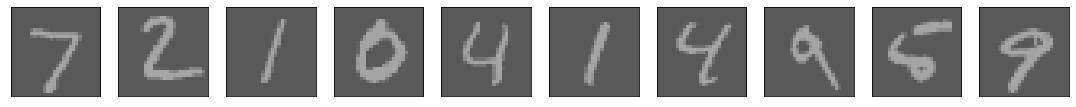

In [ ]:
plot_gallery(val_data.detach().cpu().numpy().reshape(-1, 28, 28, 1), 28, 28, n_row=1, n_col=10)

### Лица

In [ ]:
from torch.utils.data import Dataset, DataLoader

data_train_faces = data[:TRAIN_SIZE]
data_val_faces = data[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE - 43]

smiling_data_train = attrs['Smiling'][:TRAIN_SIZE].values
smiling_data_val = attrs['Smiling'][TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE-43].values

faces_train = [[data_train_faces[i], smiling_data_train[i]] for i in range(TRAIN_SIZE)]
faces_val = [[data_val_faces[i], smiling_data_val[i]] for i in range(VAL_SIZE-43)]
                                         
batch_size = 100

train_data_faces = DataLoader(dataset=faces_train, batch_size=batch_size)
val_data_faces = DataLoader(dataset=faces_val, batch_size=batch_size)

In [ ]:
INPUT_DIM_CVAE_FACES = (64*64*3) + 2
INPUT_DIM_CVAE_FACES_UNCAT = 64*64*3
HIDDEN_DIM_CVAE_FACES = 100

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.en1 = nn.Sequential(
            nn.Linear(INPUT_DIM_CVAE_FACES, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 200),
            nn.ReLU()
        )
        self.en_mu = nn.Linear(200, HIDDEN_DIM_CVAE_FACES)
        self.en_std = nn.Linear(200, HIDDEN_DIM_CVAE_FACES)
    
        self.de1 = nn.Linear(HIDDEN_DIM_CVAE_FACES + 2, 200)
        self.de2 = nn.Sequential(
            nn.Linear(200, 512),
            nn.LeakyReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, INPUT_DIM_CVAE_FACES_UNCAT)

        )
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encode(self, x):
        h1 = self.relu(self.en1(x))
        return self.en_mu(h1), self.en_std(h1)
    
    def decode(self, z, labels):
        z = torch.cat((z, labels), dim=-1)
        
        h2 = self.relu(self.de1(z))
        return self.sigmoid(self.de2(h2))
    
    def gaussian_sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    
    def forward(self, x, labels):
        mu, logvar = self.encode(x.view(-1, INPUT_DIM_CVAE_FACES))
        z = self.gaussian_sampler(mu, logvar)
        return self.decode(z, labels), mu, logvar
    
    def get_latent_code(self, x):        
        mu, logvar = self.encode(x.view(-1, INPUT_DIM_CVAE_FACES))
        return self.gaussian_sampler(mu, logvar)

[1 / 100]   Val: Average Loss = 0.67041: 100%|██████████| 31/31 [00:00<00:00, 62.69it/s]


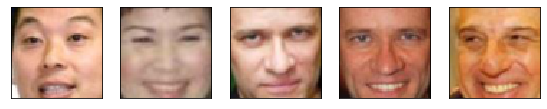

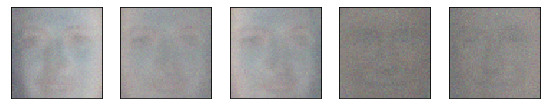

[11 / 100]   Val: Average Loss = 0.62275: 100%|██████████| 31/31 [00:00<00:00, 65.94it/s]


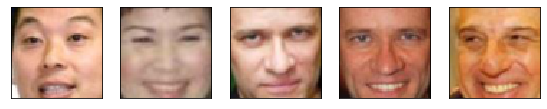

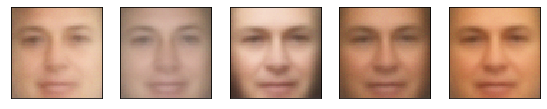

[21 / 100]   Val: Average Loss = 0.62032: 100%|██████████| 31/31 [00:00<00:00, 63.58it/s]


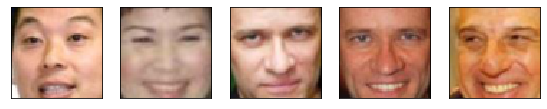

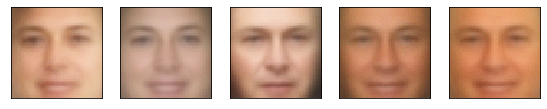

[31 / 100]   Val: Average Loss = 0.61935: 100%|██████████| 31/31 [00:00<00:00, 64.69it/s]


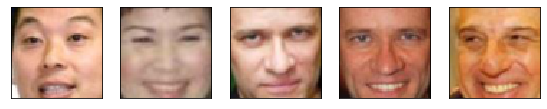

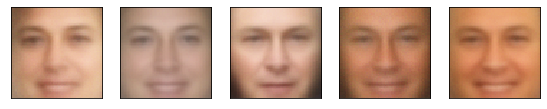

[41 / 100]   Val: Average Loss = 0.61773: 100%|██████████| 31/31 [00:00<00:00, 65.23it/s]


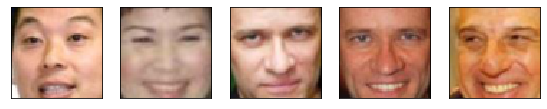

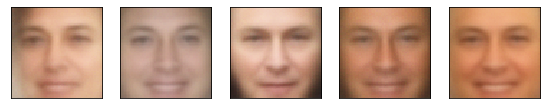

[51 / 100]   Val: Average Loss = 0.61680: 100%|██████████| 31/31 [00:00<00:00, 65.72it/s]


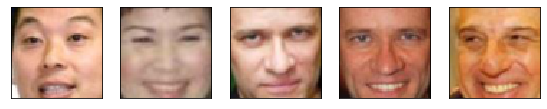

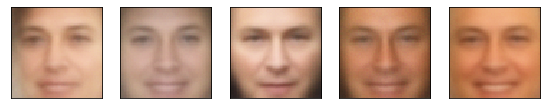

[61 / 100]   Val: Average Loss = 0.61615: 100%|██████████| 31/31 [00:00<00:00, 67.63it/s]


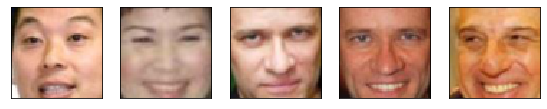

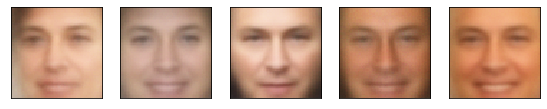

[71 / 100]   Val: Average Loss = 0.61548: 100%|██████████| 31/31 [00:00<00:00, 66.26it/s]


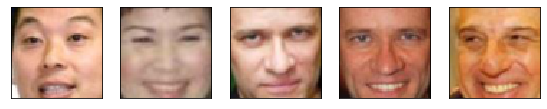

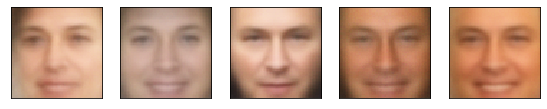

[81 / 100]   Val: Average Loss = 0.61499: 100%|██████████| 31/31 [00:00<00:00, 66.79it/s]


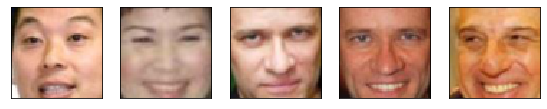

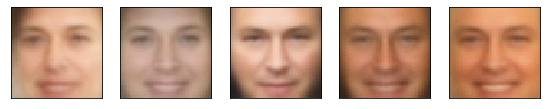

[91 / 100]   Val: Average Loss = 0.61463: 100%|██████████| 31/31 [00:00<00:00, 65.71it/s]


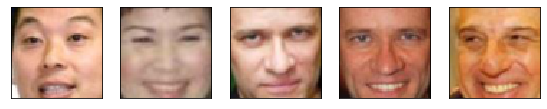

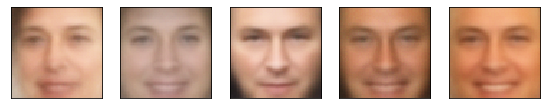

[100 / 100]   Val: Average Loss = 0.61457: 100%|██████████| 31/31 [00:00<00:00, 67.39it/s]


In [ ]:
criterion = loss_vae
cvae = CVAE().to(device)
optimizer = optim.Adam(cvae.parameters(), lr=0.0001)

fit(cvae, criterion, optimizer, train_data_faces, val_data_faces, epochs_count=100, cvae=True)

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
def onehot_for_one_value(x):
    result_tensor = torch.zeros(1, 2)

    if x >= 0:
        result_tensor[0] = torch.Tensor([1, 0])
    else:
        result_tensor[0] = torch.Tensor([0, 1])

    return result_tensor

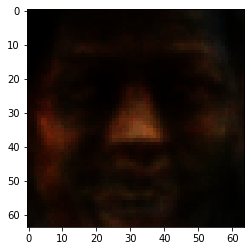

In [ ]:
face_noise = torch.Tensor(np.random.randn(1, inp_size, inp_size, 3))
face_noise = face_noise.view(-1, INPUT_DIM_CVAE_FACES_UNCAT)
face_gender = 1
face_label = torch.from_numpy(np.array(face_gender))
face_label = onehot_for_one_value(face_label)

face = torch.cat((face_noise, face_label), dim=-1)

output, mu, sigma = cvae(face.view(-1, INPUT_DIM_CVAE_FACES).to(device), face_label.to(device))
plt.imshow(output.detach().cpu().numpy().reshape(inp_size, inp_size, 3))

Крутая обложка для хоррора

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
import umap

gender = onehot(torch.from_numpy(gender_data_train.astype(np.float64)))
faces = torch.cat((torch.from_numpy(data_train_faces).view(-1, INPUT_DIM_CVAE_FACES_UNCAT).float(), gender), dim=-1)

latent_representation = cvae.get_latent_code(torch.Tensor(faces).view(-1, INPUT_DIM_CVAE_FACES).to(device))
X_embedded = umap.UMAP(n_neighbors=10, n_components=2).fit_transform(latent_representation.detach().cpu().numpy())

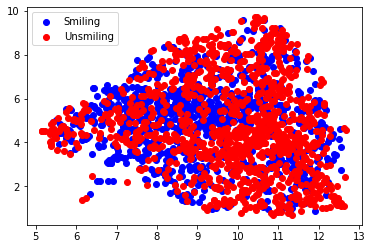

In [ ]:
man = attrs['Smiling'][0:TRAIN_SIZE][attrs['Smiling'] >= 1.5].index
women = attrs['Smiling'][0:TRAIN_SIZE][attrs['Smiling'] < -1.5].index

man = [X_embedded[i] for i in man]
women = [X_embedded[j] for j in women]

man = np.array(man)
women = np.array(women)

plt.figure()

plt.scatter(man[:, 0], man[:, 1], label='Smiling', color='blue')

plt.scatter(women[:, 0], women[:, 1], label='Unsmiling', color='red')
plt.legend()

plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

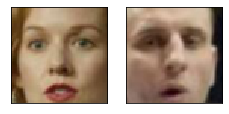

In [ ]:
X = torch.FloatTensor(X_val[3]).view(-1, 64*64*3)
Y = torch.FloatTensor(X_val[-1]).view(-1, 64*64*3)

plot_gallery([X, Y], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

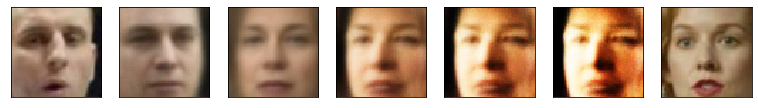

In [ ]:
X_latent = vanila_vae_t.get_latent_code(torch.FloatTensor(X).to(device))
Y_latent = vanila_vae_t.get_latent_code(torch.FloatTensor(Y).to(device))

morph_images = [Y]
alpha = 0.0

for alpha in range(0, 5):
    image = alpha * X_latent + (1 - alpha)*Y_latent
    result = vanila_vae_t.decode(image)
    morph_images.append(result)

    alpha += 0.1

morph_images.append(X)

for i in range(1, len(morph_images) - 1):
    morph_images[i] = morph_images[i].view(64, 64, 3).detach().cpu().numpy()

plot_gallery(morph_images, IMAGE_H, IMAGE_W, n_row=1, n_col=7)

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

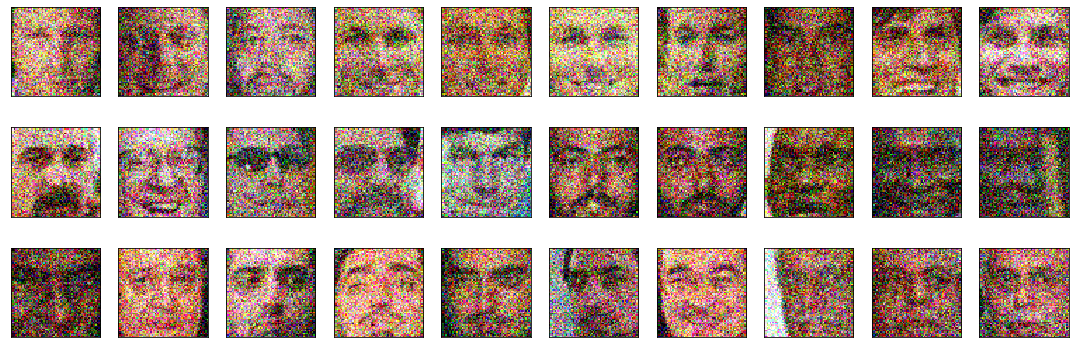

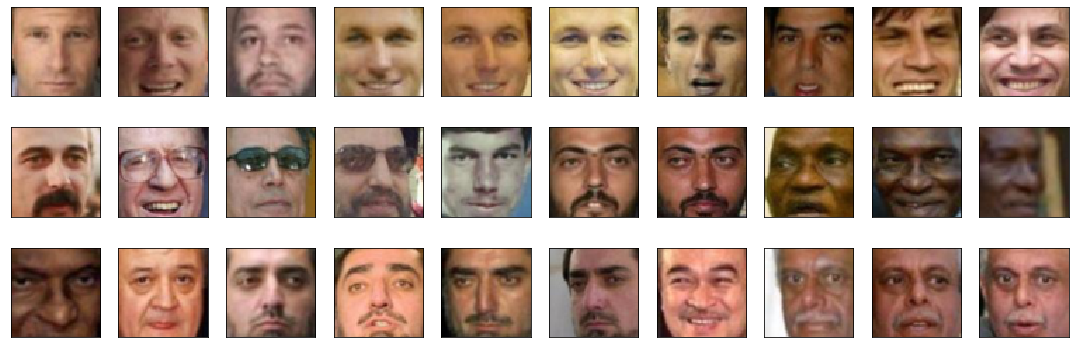

In [ ]:
noise_factor = 0.25

# X = [normalization(image) for image in data] 
X_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape) 

noised_train = X_noisy[:TRAIN_SIZE]
noised_val = X_noisy[TRAIN_SIZE : TRAIN_SIZE + VAL_SIZE]

batch_size = 100

train_noised = DataLoader(dataset=noised_train, batch_size=batch_size)
val_noised = DataLoader(dataset=noised_val, batch_size=batch_size)
plot_gallery(noised_train, 64, 64, 3, 10)
plot_gallery(X_train, 64, 64, 3, 10)

[1 / 70]   Val: Average Loss = 0.08449: 100%|██████████| 32/32 [00:00<00:00, 68.98it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


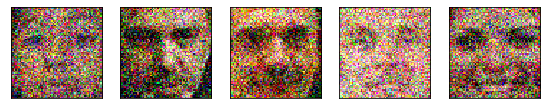

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


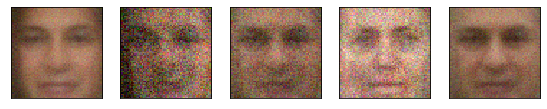

[51 / 70]   Val: Average Loss = 0.07471: 100%|██████████| 32/32 [00:00<00:00, 69.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


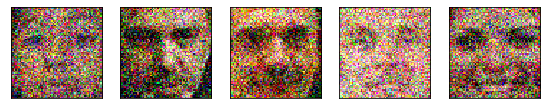

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


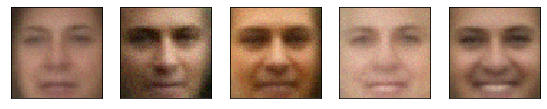

[70 / 70]   Val: Average Loss = 0.07100: 100%|██████████| 32/32 [00:00<00:00, 71.50it/s]


In [ ]:
noise_autoencoder = Autoencoder(inp_size, dim_code).to(device)
optimizer = optim.Adam(noise_autoencoder.parameters(), lr=0.001)

fit(noise_autoencoder, mse, optimizer, train_noised, val_noised, epochs_count=70, show_img_val=50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


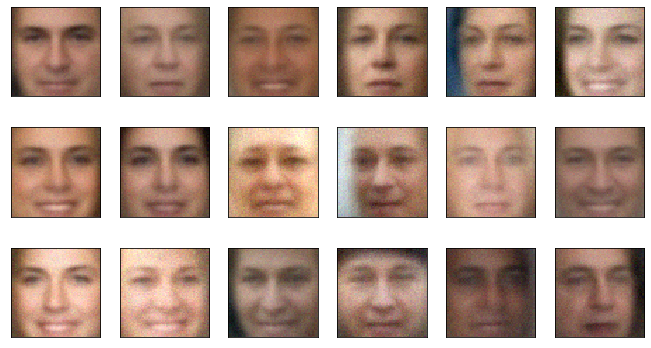

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------------------------------------------------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

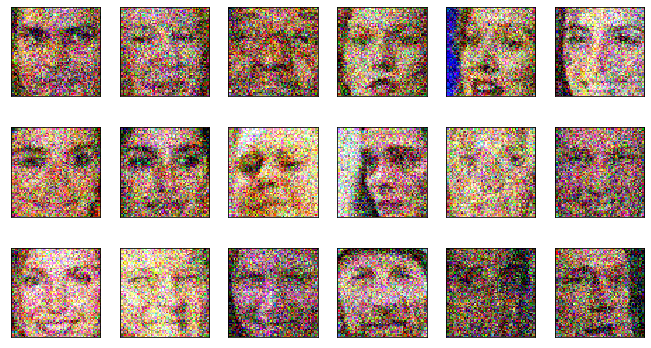

In [ ]:
val_dataloader_vis = data_utils.DataLoader(noised_val, batch_size=32, drop_last=True)
val_data = next(iter(val_dataloader_vis))
val_data_tr = val_data.view(-1, inp_size * inp_size * 3).to(device)
result = noise_autoencoder(val_data_tr.float())[0].detach().cpu().view(-1, 3, inp_size, inp_size)
plot_gallery(result, IMAGE_H, IMAGE_W)
print('-'*80)
plot_gallery(val_data.detach().cpu().view(-1, 3, inp_size, inp_size), IMAGE_H, IMAGE_W)

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

# Bonus 3: Image Retrieval (2 балла)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
autoencoder.eval()
tr = torch.tensor(X_train).view(-1, inp_size*inp_size*3).float().to(device)
codes = autoencoder.encoder(tr)

In [ ]:
from sklearn.neighbors import NearestNeighbors
lshf = NearestNeighbors(n_neighbors=100, metric="cosine").fit(codes.detach().cpu().numpy())

In [ ]:
def get_similar(image, n_neighbors=5):
    # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
    # прогоняет векторы через декодер и получает картинки ближайших людей
    image = torch.Tensor(image).view(-1, inp_size * inp_size * 3).to(device)
    code = autoencoder.encoder(image)
    code = code.detach().cpu().numpy()
    
    (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)
    res = [X_train[i] for i in idx.tolist()]

    return distances, res

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances, neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[10,10])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

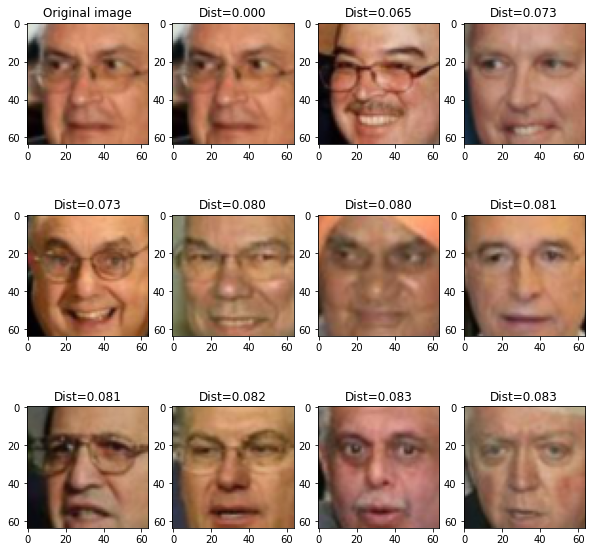

In [ ]:
show_similar(X_train[54])

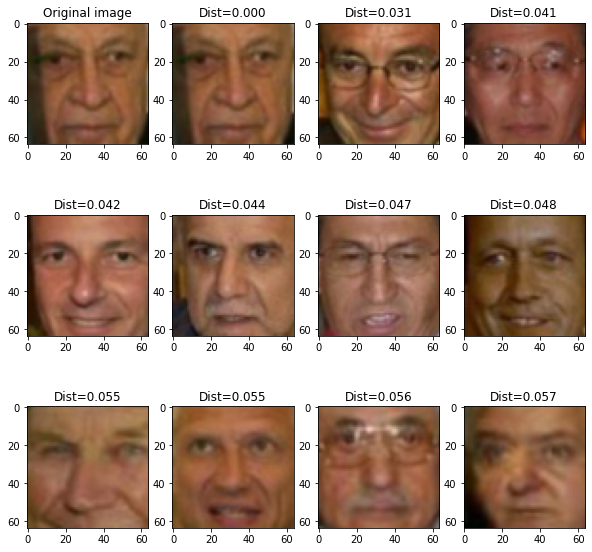

In [ ]:
indx = np.random.randint(0, 1000, 1)[0]
show_similar(X_train[indx])

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!